In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xg
import numpy as np

from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.preprocessing import Imputer, LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier

pd.set_option('chained_assignment',None)
%matplotlib inline

/home/deadhand/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
titanic_train = pd.read_csv("../data/train.csv")
titanic_test = pd.read_csv("../data/test.csv")

In [3]:
titanic_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [4]:
titanic_test.sample(20)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
298,1190,1,"Loring, Mr. Joseph Holland",male,30.0,0,0,113801,45.5000,NaN,S
191,1083,1,"Salomon, Mr. Abraham L",male,NaN,0,0,111163,26.0000,NaN,S
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
388,1280,3,"Canavan, Mr. Patrick",male,21.0,0,0,364858,7.7500,NaN,Q
61,953,2,"McCrae, Mr. Arthur Gordon",male,32.0,0,0,237216,13.5000,NaN,S
238,1130,2,"Hiltunen, Miss. Marta",female,18.0,1,1,250650,13.0000,NaN,S
128,1020,2,"Bowenur, Mr. Solomon",male,42.0,0,0,211535,13.0000,NaN,S
161,1053,3,"Touma, Master. Georges Youssef",male,7.0,1,1,2650,15.2458,NaN,C
404,1296,1,"Frauenthal, Mr. Isaac Gerald",male,43.0,1,0,17765,27.7208,D40,C
212,1104,2,"Deacon, Mr. Percy William",male,17.0,0,0,S.O.C. 14879,73.5000,NaN,S


I'm taking out the names for now

In [5]:
X_train = titanic_train[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Cabin', 'Name']]
y_train = titanic_train['Survived']

X_test = titanic_test[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Cabin', 'Name']]

In [6]:
# Cabin is a bit unwieldy. I'm going to just take the general area.
# "U" means unknown

X_train.loc[:, 'Cabin'].fillna('U', inplace = True)
X_train.loc[:, 'Cabin'] = X_train.loc[:, 'Cabin'].apply(lambda n: n[0])

X_test.loc[:, 'Cabin'].fillna('U', inplace = True)
X_test.loc[:, 'Cabin'] = X_test.loc[:, 'Cabin'].apply(lambda n: n[0])

In [7]:
# There are also missing values in Embarked

X_train.loc[:, 'Embarked'].fillna('U', inplace = True)
X_test.loc[:, 'Embarked'].fillna('U', inplace = True)

In [8]:
# Let's also try to do something with names
# X_train.loc[:, 'LastName'] = X_train.loc[:, "Name"].apply(lambda x: x.split(' ')[0])
X_train.loc[:, 'Honorific'] = X_train.loc[:, "Name"].apply(lambda x: x.split(', ')[1].split(' ')[0])
X_train.drop('Name', axis = 1, inplace = True)

# X_test.loc[:, 'LastName'] = X_test.loc[:, "Name"].apply(lambda x: x.split(' ')[0])
X_test.loc[:, 'Honorific'] = X_test.loc[:, "Name"].apply(lambda x: x.split(', ')[1].split(' ')[0])
X_test.drop('Name', axis = 1, inplace = True)

In [9]:
# I tried to bin Age but wasn't able to find anything that improved cross-validation

X_train_Age = pd.qcut(X_train.Age, 5)

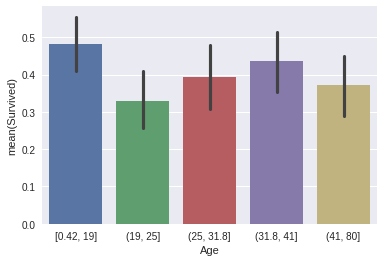

In [10]:
df_train = pd.DataFrame({'Age': X_train_Age,
                         'Survived': y_train})

sns.barplot(x="Age", y="Survived", data=df_train)

In [11]:
categories_to_encode = ['Embarked', 'Cabin', 'Sex', 'Honorific']

# Need to temporarily merge in case of new labels in test
X_combined = pd.concat([X_train[categories_to_encode], X_test[categories_to_encode]])

for category in categories_to_encode:
    labels = LabelEncoder()
    labels.fit(X_combined[category])    
    X_train[category] = labels.transform(X_train[category])
    X_test[category] = labels.transform(X_test[category])

In [12]:
mean_imputer = Imputer(strategy='mean')
X_train[['Age', 'Fare']] = mean_imputer.fit_transform(X_train[['Age', 'Fare']])
X_test[['Age', 'Fare']] = mean_imputer.transform(X_test[['Age', 'Fare']])
# Would use MICE, but I'm getting compiler errors

In [13]:
# This makes a big difference for SVC and KNN but not the others
# RF and XGB are feature invariant and maybe RC is regularizing 
# the scaled features?

scaler = StandardScaler()
X_train[['Age', 'Fare']] = scaler.fit_transform(X_train[['Age', 'Fare']])
X_test[['Age', 'Fare']] = scaler.transform(X_test[['Age', 'Fare']])

In [14]:
X_train.sample(20)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin,Honorific
544,1,1,1.562241,1,0,1.494412,0,2,12
4,3,1,0.407926,0,0,-0.486337,2,8,12
510,3,1,-0.053800,0,0,-0.492378,1,8,12
387,2,0,0.484880,0,0,-0.386671,2,8,9
681,1,1,-0.207709,0,0,0.896497,0,3,12
767,3,0,0.061631,0,0,-0.492378,1,8,9
227,3,1,-0.707912,0,0,-0.502445,2,8,12
590,3,1,0.407926,0,0,-0.504962,2,8,12
172,3,0,-2.208522,1,1,-0.424256,2,8,9
657,3,0,0.177063,1,1,-0.336334,1,8,13


In [15]:
X_combined = pd.concat([X_train, X_test])
dummy_combined = pd.get_dummies(X_combined, 
               columns = ['Pclass', 'Sex', 'Embarked', 'Cabin', 'Honorific'], 
               drop_first=True)

X_train = dummy_combined.iloc[:X_train.shape[0], :]
X_test = dummy_combined.iloc[X_train.shape[0]:, :]

# Let's get a baseline with a few common models

In [16]:
accuracy_scorer = make_scorer(accuracy_score)
cross_val_scores = []

In [17]:
ridge = RidgeClassifier()
cvs = cross_val_score(ridge, X_train, y_train, scoring=accuracy_scorer, cv = 10).mean()
print(cvs)
cross_val_scores.append(cvs)

0.82834865509


In [18]:
xgb = xg.XGBClassifier()
cvs = cross_val_score(xgb, X_train, y_train, scoring=accuracy_scorer, cv = 10).mean()
print(cvs)
cross_val_scores.append(cvs)

0.836238508682


In [19]:
random_forest = RandomForestClassifier()
cvs = cross_val_score(random_forest, X_train, y_train, scoring=accuracy_scorer, cv = 10).mean()
print(cvs)
cross_val_scores.append(cvs)

0.8204329815


In [20]:
svc = SVC()
cvs = cross_val_score(svc, X_train, y_train, scoring=accuracy_scorer, cv = 10).mean()
print(cvs)
cross_val_scores.append(cvs)

0.833891442515


In [21]:
knn = KNeighborsClassifier()
cvs = cross_val_score(knn, X_train, y_train, scoring=accuracy_scorer, cv = 10).mean()
print(cvs)
cross_val_scores.append(cvs)

0.826062875951


In [22]:
naive_bayes = BernoulliNB()
cvs = cross_val_score(naive_bayes, X_train, y_train, scoring=accuracy_scorer, cv = 10).mean()
print(cvs)
cross_val_scores.append(cvs)

0.783465554421


In [23]:
mlp = MLPClassifier()
cvs = cross_val_score(mlp, X_train, y_train, scoring=accuracy_scorer, cv = 10).mean()
print(cvs)
cross_val_scores.append(cvs)

0.809272216547


## Ensemble Everything in a Voting Classifier

In [24]:
normed_cross_val_scores = cross_val_scores / sum(cross_val_scores)
voter = VotingClassifier([('ridge', ridge), 
                          ('xgb', xgb),
                          ('svc', svc),
                          ('knn', knn),
                          ('naive_bayes', naive_bayes),
                          ('mlp', mlp),
                          ('random_forest', random_forest)],
                         weights = list(normed_cross_val_scores))
cross_val_score(voter, X_train, y_train, scoring=accuracy_scorer, cv = 10).mean()

0.8395471569628874

In [25]:
voter.fit(X_train, y_train)


/home/deadhand/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


VotingClassifier(estimators=[('ridge', RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='auto',
        tol=0.001)), ('xgb', XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_...imators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))],
         n_jobs=1, voting='hard',
         weights=[0.14436915293166208, 0.1457442399470715, 0.14298956586524389, 0.14533518036525878, 0.14397077478960654, 0.13654667964725339, 0.14104440645390395])

In [26]:
submission = pd.DataFrame({'PassengerId': titanic_test['PassengerId'],
                          'Survived': voter.predict(X_test)})
submission.to_csv('../results/voting_submission.csv', index = False)

### This overfit massively. I'm also submitting my one best model

In [27]:
xgb.fit(X_train, y_train)

xg_submission = pd.DataFrame({'PassengerId': titanic_test['PassengerId'],
                          'Survived': xgb.predict(X_test)})
submission.to_csv('../results/xgb_submission.csv', index = False)

### Possible TODOs

- Get MICE working for imputation
- Hyperparameter optimization